In [7]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prince
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
## my functions/classes
from mb_xai import mb_utils
import mb_xai.gut_data as gd

In [8]:
FIG_SAVE_LOC = "../figures/"
# DATA_LOC = '../../../Data/community_optimization/data/'
DATA_LOC = '../../../Data/microbiome_xai/'

In [9]:
gut_data = gd.GutData()
gut_data.load_data(
    # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
    # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
    # FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/SILVA_genus_counts_fd.csv',
    # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
)
gut_data.norm_abundances(filter_model=True, add_delta=True) ## Filters genus to those in model, adds small value to abundaces
gut_data.X_df = gut_data.asv_df.T.copy()
gut_data.sample_list = gut_data.X_df.index.to_list()
# gut_data.set_vegan_df(sample_num=40)
## Set vegan df changes X_df and y_df and will therefore change medium_df. Be sure to run medium df after setting samples
medium_df = pd.DataFrame(1000, columns=gut_data.com_model.medium.keys(), index = gut_data.X_df.index)
gut_data.sample_medium_dict = medium_df.T.to_dict()
gut_data.return_fluxes = True
gut_data.pfba_bool = True # otherwise optimum values will not be fluxes but intead min(sum flux)

Fixed EX_tDHNACOA(e)
... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
# of genus in model and not filterd out of QA/QC: 50, # of genus not in model:0


In [4]:
# gut_data_1 = gd.GutData()
# gut_data_1.load_data(
#     # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
#     FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
#     # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
#     FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
#     # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
#     FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
#     DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
# )

# gut_data_2 = gd.GutData()
# gut_data_2.load_data(
#     # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
#     # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
#     FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
#     # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
#     FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
#     # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
#     FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
#     DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
# )

# list(set(list(gut_data_2.com_model.taxonomy.index))-set(list(gut_data_1.com_model.taxonomy.index)))

Fixed EX_tDHNACOA(e)
Fixed EX_tDHNACOA(e)


In [11]:
sol = gut_data.com_model.optimize(fluxes=True)
rxn_content_df = sol.fluxes.copy()
rxn_content_df[rxn_content_df.notnull()==True] = 1
rxn_content_df.fillna(0, inplace=True)
rxn_content_df.drop("medium", inplace=True)

In [12]:
from sklearn.decomposition import PCA

def plot_pca(X, plot_comps=[0,1], target_names=["non-vegan", "vegan"]):
    """Fits and plots PCA of the two dimensions
    Plot_comps specifies which components to drop
    target_names correspond to [0, 1], default just the vegan
    """

    n_components = 3
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    colors = ['darkorange', 'turquoise'] # "navy"
    
    for X_transformed, title in [(X_pca, "PCA")]:
        plt.figure(figsize=(4, 4))
        for color, i, target_name in zip(colors, [0,1], target_names):
            plt.scatter(X_transformed[y == i, plot_comps[0]], X_transformed[y == i, plot_comps[1]],
                        color=color, lw=2, label=target_name)

        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.axis([-1, 1, -1, 1])
    plt.show()

In [13]:
genus_phylo_class_df = pd.read_csv(DATA_LOC+"agp_data/genus_phylo_class.csv",index_col=0)
genus_phylo_class_df["phylum"] = genus_phylo_class_df["phylum"].str.lower()
genus_phylo_class_df["class"] = genus_phylo_class_df["class"].str.lower()
# genus_phylo_class_df

In [14]:
# X = rxn_content_df.T.copy()

X = rxn_content_df
n_components=3

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
X_pca_df = pd.DataFrame(X_pca, index=rxn_content_df.index, columns=range(n_components))
X_pca_df.columns = ["PCA comp "+str(x) for x in X_pca_df.columns]
X_pca_df["phylum"] = genus_phylo_class_df["phylum"]
X_pca_df["class"] = genus_phylo_class_df["class"]
# X_pca_df.columns = [str(x) for x in X_pca_df.columns]
X_pca_df.head()

,PCA comp 0,PCA comp 1,PCA comp 2,phylum,class
compartment,,,,,
acinetobacter,-9.784998,14.763583,22.025976,proteobacteria,gammaproteobacteria
akkermansia,-15.222350,3.612170,-0.115806,verrucomicrobia,verrucomicrobiae
alistipes,3.952631,27.459558,-19.423856,bacteroidetes,bacteroidia
anaerostipes,-4.976806,-11.664730,-2.241652,firmicutes,clostridia
bacteroides,13.066556,35.515858,-9.270010,bacteroidetes,bacteroidia


In [15]:
X_pca_df

,PCA comp 0,PCA comp 1,PCA comp 2,phylum,class
compartment,,,,,
acinetobacter,-9.784998,14.763583,22.025976,proteobacteria,gammaproteobacteria
akkermansia,-15.222350,3.612170,-0.115806,verrucomicrobia,verrucomicrobiae
alistipes,3.952631,27.459558,-19.423856,bacteroidetes,bacteroidia
anaerostipes,-4.976806,-11.664730,-2.241652,firmicutes,clostridia
bacteroides,13.066556,35.515858,-9.270010,bacteroidetes,bacteroidia
barnesiella,-15.023364,4.850862,-2.338710,bacteroidetes,bacteroidia
bifidobacterium,24.427192,-4.384152,2.742068,actinobacteria,actinobacteria
bilophila,-15.627658,2.195376,1.606257,proteobacteria,gammaproteobacteria
blautia,-0.612213,-10.580079,0.923850,firmicutes,clostridia


In [16]:
pca.explained_variance_ratio_

array([0.24639835, 0.19012076, 0.10059857])

<AxesSubplot:xlabel='PCA comp 0', ylabel='PCA comp 1'>

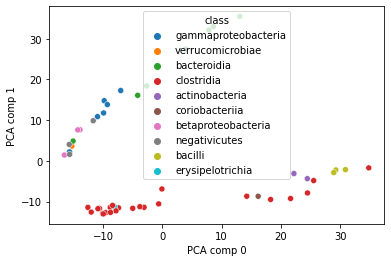

In [17]:
sns.scatterplot(data=X_pca_df, x="PCA comp 0", y="PCA comp 1", hue="class")
# sns.scatterplot(data=X_pca_df, x="0", y="1")

[16:02:02] WARNING  The PostScript backend does not support transparency;   ]8;id=145521;file:///home/eskavvas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_ps.py\backend_ps.py]8;;\:794
                    partially transparent artists will be rendered opaque.

           WARNING  The PostScript backend does not support transparency;   ]8;id=875054;file:///home/eskavvas/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_ps.py\backend_ps.py]8;;\:794
                    partially transparent artists will be rendered opaque.

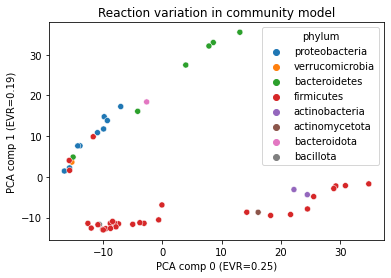

In [18]:
g = sns.scatterplot(data=X_pca_df, x="PCA comp 0", y="PCA comp 1", hue="phylum")
g.axes.set_xlabel("PCA comp 0 (EVR=%.2f)"%(pca.explained_variance_ratio_[0]))
g.axes.set_ylabel("PCA comp 1 (EVR=%.2f)"%(pca.explained_variance_ratio_[1]))
g.axes.set_title("Reaction variation in community model")
g.figure.savefig(FIG_SAVE_LOC+"pca_reactions_phylum.png")
g.figure.savefig(FIG_SAVE_LOC+"pca_reactions_phylum.svg")
g.figure.savefig(FIG_SAVE_LOC+"pca_reactions_phylum.eps")

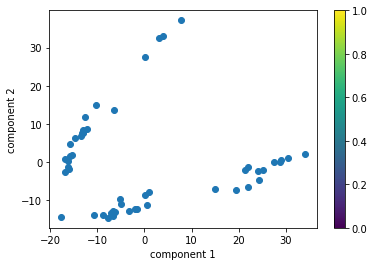

In [10]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            # c=digits.target, edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('spectral', 10)
            )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [42]:
mca = prince.MCA(n_components=3)
mca = mca.fit(rxn_content_df) # same as calling ca.fs_r(1)
mca_df = mca.transform(rxn_content_df) # same as calling ca.fs_r_sup(df_new) for *another* test set.
print(mca_df)

                               0             1             2
acinetobacter          -0.084027  5.408020e-01 -6.710239e-01
actinomyces            -0.084027 -2.220261e-01 -2.969426e-01
akkermansia            -0.084027  5.136350e-01 -4.427752e-01
alistipes              -0.084027  8.601727e-01  9.662264e-01
anaerostipes           -0.084027 -2.338981e-01 -3.203733e-01
bacteroides            -0.084027  8.097431e-01  8.857345e-01
barnesiella            -0.084027  6.035641e-01 -3.305427e-01
bifidobacterium        -0.084027 -6.304755e-01  2.623247e-01
bilophila              -0.084027  4.671210e-01 -5.345155e-01
blautia                -0.084027 -2.775316e-01 -2.777102e-01
brevundimonas          -0.084027  4.591275e-01 -5.696526e-01
butyricicoccus         -0.084027 -1.847614e-01 -3.729301e-01
christensenellaceae    -0.084027 -1.407503e-01 -4.168341e-01
clostridium            -0.084027 -6.827289e-01  2.509507e-01
comamonas              -0.084027  5.091630e-01 -6.590691e-01
coprococcus            -

In [43]:
mca.eigenvalues_

[0.9999999999999909, 0.31754379222509965, 0.2607869841221395]

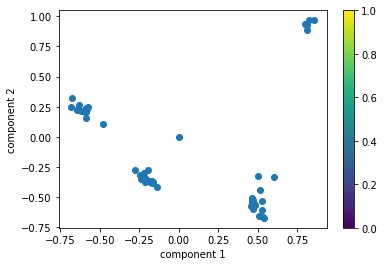

In [44]:
plt.scatter(mca_df.iloc[:, 1], mca_df.iloc[:, 2],
            # c=digits.target, edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('spectral', 10)
            )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [13]:
ax = mca.plot_coordinates(
     X=rxn_content_df,
     ax=None,
     figsize=(6, 6),
     show_row_points=True, #True,
     row_points_size=10,
     show_row_labels= False,# False,
     show_column_points=True, # True
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
     )

KeyboardInterrupt: 